In [17]:
import numpy as np
import torch
import math
import gpytorch
from matplotlib import pyplot as plt


In [18]:

r_short = 0.33
m_short = 0.27
r_long = 0.64
m_long=0.29

zetha = 0.012
g = 9.81

Q=torch.diag(torch.Tensor([1,100,10,200]))
R=10



# GP using gpytorch

### Define training data

In [19]:
train_x = torch.linspace(0,1,100)
train_y = torch.sin(train_x * (2*math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [43]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [48]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: -0.130   lengthscale: 0.264   noise: 0.034
Iter 2/50 - Loss: -0.126   lengthscale: 0.242   noise: 0.037
Iter 3/50 - Loss: -0.130   lengthscale: 0.258   noise: 0.035
Iter 4/50 - Loss: -0.129   lengthscale: 0.275   noise: 0.033
Iter 5/50 - Loss: -0.128   lengthscale: 0.282   noise: 0.032
Iter 6/50 - Loss: -0.128   lengthscale: 0.279   noise: 0.032
Iter 7/50 - Loss: -0.129   lengthscale: 0.272   noise: 0.033
Iter 8/50 - Loss: -0.130   lengthscale: 0.264   noise: 0.034
Iter 9/50 - Loss: -0.129   lengthscale: 0.257   noise: 0.035
Iter 10/50 - Loss: -0.129   lengthscale: 0.254   noise: 0.036
Iter 11/50 - Loss: -0.129   lengthscale: 0.255   noise: 0.036
Iter 12/50 - Loss: -0.129   lengthscale: 0.258   noise: 0.035
Iter 13/50 - Loss: -0.130   lengthscale: 0.264   noise: 0.034
Iter 14/50 - Loss: -0.130   lengthscale: 0.270   noise: 0.033
Iter 15/50 - Loss: -0.129   lengthscale: 0.274   noise: 0.033
Iter 16/50 - Loss: -0.129   lengthscale: 0.276   noise: 0.033
Iter 17/50 - Loss

In [41]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

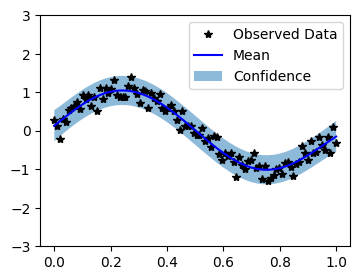

In [42]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])